# Generalized Additive Models

This Jupyter notebook demonstrates the use of a traditional GAM method using the PyGAM library for a tabular classification.

### Classification dataset

https://archive.ics.uci.edu/dataset/2/adult





##  **1. Import modules**


The dataset we are using is the 1994 Census database with minimal missing values. The task is a binary classification i.e. predicting if an individual's annual income is over $50,000.

| Column          | Description                                                                 |
|-----------------|-----------------------------------------------------------------------------|
| age             | Age of the individual                                                       |
| workclass       | Type of employment (e.g., Private, Self-emp-not-inc, etc.)                  |
| fnlwgt          | Final weight, a measure of the number of people the observation represents  |
| education       | Highest level of education achieved (e.g., Bachelors, HS-grad, etc.)        |
| education-num   | Number of years of education                                                |
| marital-status  | Marital status (e.g., Never-married, Married-civ-spouse, etc.)              |
| occupation      | Type of occupation (e.g., Adm-clerical, Exec-managerial, etc.)              |
| relationship    | Relationship status (e.g., Not-in-family, Husband, etc.)                    |
| race            | Race of the individual (e.g., White, Black, Asian-Pac-Islander, etc.)       |
| sex             | Gender of the individual (Male or Female)                                   |
| capital-gain    | Capital gains                                                               |
| capital-loss    | Capital losses                                                              |
| hours-per-week  | Number of hours worked per week                                             |
| native-country  | Country of origin (e.g., United-States, Mexico, etc.)                       |
| income          | Income level (<=50K or >50K)                                                |



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score,PrecisionRecallDisplay, RocCurveDisplay, classification_report
import os
from pygam import LogisticGAM, s, f
import joblib

np.random.seed(42)


## 2.Load dataset

In [8]:
def load_adult_dataset(directory: str, filename: str = "adult.data") -> pd.DataFrame:
    """
    Loads the Adult Income dataset from a local directory.

    Args:
        directory (str): The path to the local directory containing the dataset file.

    Returns:
        df (pd.DataFrame): The cleaned Adult dataset with column names.
    """
    file_path = os.path.join(directory, filename)

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset file not found at {file_path}. Please check the directory path.")

    # Load dataset
    df = pd.read_csv(
        file_path,
        header=None,
        names=[
            "age", "workclass", "fnlwgt", "education", "education-num",
            "marital-status", "occupation", "relationship", "race", "sex",
            "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
        ],
        na_values=" ?"  # Convert missing values represented as " ?" to NaN
    )
    
    # Drop rows with missing values (optional)
    df.dropna(inplace=True)

    return df


In [9]:
# Load dataset
directory = "../datasets/adult"
df = load_adult_dataset(directory, filename="adult.data")
display(df.head())


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## **3. Dataset Preprocessing**

- Categorical variables are integer-encoded  while the numerical variables are z-score scaled.
- Dataset is split into 80% train and 20% validation





In [10]:
def preprocess_data(df):
    # Encode target variable
    df["income"] = df["income"].apply(lambda x: 1 if x == " >50K" else 0)
    df.drop(columns=["education"], inplace=True)  # Highly correlated with education-num    
    df.drop(columns=["fnlwgt"], inplace=True)  # Not relevant for prediction

    # Identify categorical and numerical features
    categorical_features = ["workclass", "marital-status", "occupation", 
                            "relationship", "race", "sex", "native-country"]
    numerical_features = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

    # Convert categorical variables to integers using sklearn's LabelEncoder
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Save the mapping for future inference
    joblib.dump(label_encoders, "label_encoders.pkl")

    # Scale numerical features
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    # Save scaling parameters (for future inference)
    scaler_mean = scaler.mean_
    scaler_var = scaler.var_

    return df, categorical_features, numerical_features, scaler_mean, scaler_var

# Preprocess the dataset
df, categorical_features, numerical_features, scaler_mean, scaler_var = preprocess_data(df)

# Split dataset into training and test sets
X = df.drop("income", axis=1)
y = df["income"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


##  **4. Define the GAM model and start training**

- First, we need to define the terms for the Generalized Additive Model (GAM).
- We will use **smooth terms** for numerical features and **factor terms** for categorical features.
- For classification problems, we must use a **logit link function** and a **binomial distribution**
- For simplicity, `pyGAM` has the `LogisticGAM` class that is optimized for classification task incorporating the proper distribution and link functions
- The `lam` (lambda) controls the smoothness of the shape functions.
	-	Higher lambda = More regularization (less flexibility, avoids overfitting)
	-	Lower lambda = More flexibility (higher variance, risk of overfitting)
	-	We can use a built-in grid search to find the optimal lambda:

In [11]:
# Let's construct the GAM model

# We first initialize the first term
terms = s(0)

# Add numerical features using smooth functions
for i in range(1, len(numerical_features)):
    terms += s(i)

# Tehn add factor terms for categorical variables dynamically
for i in range(len(numerical_features), X_train.shape[1]):
    terms += f(i)

# Convert to NumPy arrays to avoid index errors
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

# Perform grid search for optimal lambda
lam_values = np.logspace(-3, 3, 10)  # Test lambda from 0.001 to 1000
gam = LogisticGAM(terms).gridsearch(X_train_np, y_train_np, lam=lam_values)

# Model summary
print(gam.summary())

100% (10 of 10) |########################| Elapsed Time: 0:02:02 Time:  0:02:020:12


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    185.1337
Link Function:                        LogitLink Log Likelihood:                                 -7145.1866
Number of Samples:                        24129 AIC:                                            14660.6405
                                                AICc:                                           14663.5502
                                                UBRE:                                               2.6137
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4711
Feature Function                  Lam

/tmp/ipykernel_26096/3813238078.py:23: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


## **5. Model Performance on validation set**

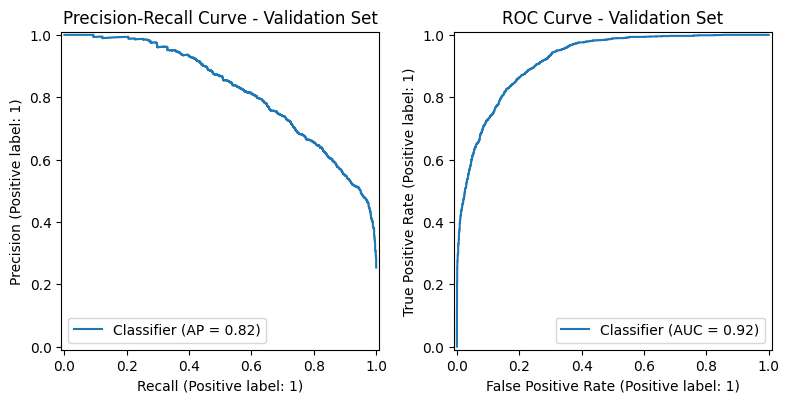

Classification Report - Validation Set:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      4503
           1       0.78      0.64      0.71      1530

    accuracy                           0.86      6033
   macro avg       0.83      0.79      0.81      6033
weighted avg       0.86      0.86      0.86      6033



In [12]:
# Predict the target variable on the test set
y_pred = gam.predict(X_val)
y_pred_proba = gam.predict_proba(X_val)

# Calculate the performance metrics including F1 score, ROC_AUC and confusion matrix


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Precision-Recall Display
PrecisionRecallDisplay.from_predictions(y_val, gam.predict_proba(X_val), ax=axs[0])
axs[0].set_title('Precision-Recall Curve - Validation Set')

# ROC Curve Display
RocCurveDisplay.from_predictions(y_val, gam.predict_proba(X_val), ax=axs[1])
axs[1].set_title('ROC Curve - Validation Set')

plt.tight_layout()
plt.show()
print("Classification Report - Validation Set:\n", classification_report(y_val, y_pred))



## **6. Performence on Test Set**

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
6,34,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K.


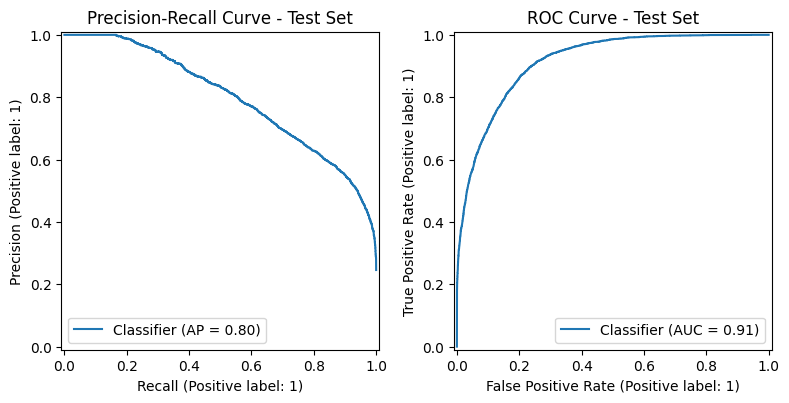

Classification Report - Test Set:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91     11360
           1       0.75      0.62      0.68      3700

    accuracy                           0.86     15060
   macro avg       0.82      0.78      0.79     15060
weighted avg       0.85      0.86      0.85     15060



In [13]:
# now preprocess the actual test set and evaluate the model on the test set

# Load the test set
directory = "../datasets/adult"
df_test = load_adult_dataset(directory, filename="adult.test")
display(df_test.head())

# Convert 'age' column to numeric
df_test['age'] = pd.to_numeric(df_test['age'], errors='coerce')


#preprocess the test set
def preprocess_test_data(df, label_encoders, scaler_mean, scaler_var):
    # Encode target variable
    df["income"] = df["income"].apply(lambda x: 1 if x == " >50K." else 0)
    
    df.drop(columns=["education"], inplace=True)  # Highly correlated with education-num
    df.drop(columns=["fnlwgt"], inplace=True)  # Not relevant for prediction

    # Identify categorical and numerical features
    categorical_features = ["workclass", "marital-status", "occupation", 
                            "relationship", "race", "sex", "native-country"]
    
    numerical_features = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

    # Convert categorical variables to integers using the saved LabelEncoders
    label_encoders = joblib.load("label_encoders.pkl")
    for col in categorical_features:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # Scale numerical features using the saved scaling parameters
    df[numerical_features] = (df[numerical_features] - scaler_mean) / np.sqrt(scaler_var)
    
    return df

label_encoders = joblib.load("label_encoders.pkl")
# Preprocess the test set
df_test = preprocess_test_data(df_test, label_encoders, scaler_mean, scaler_var)

#predict the target variable on the test set
X_test = df_test.drop("income", axis=1)
y_test = df_test["income"]


# Predict the target variable on the test set
y_pred = gam.predict(X_test)
y_pred_proba = gam.predict_proba(X_val)

# Calculate the performance metrics including F1 score, ROC_AUC and confusion matrix

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Precision-Recall Display
PrecisionRecallDisplay.from_predictions(y_test, gam.predict_proba(X_test), ax=axs[0])
axs[0].set_title('Precision-Recall Curve - Test Set')

# ROC Curve Display
RocCurveDisplay.from_predictions(y_test, gam.predict_proba(X_test), ax=axs[1])
axs[1].set_title('ROC Curve - Test Set')

plt.tight_layout()
plt.show()
print("Classification Report - Test Set:\n", classification_report(y_test, y_pred))

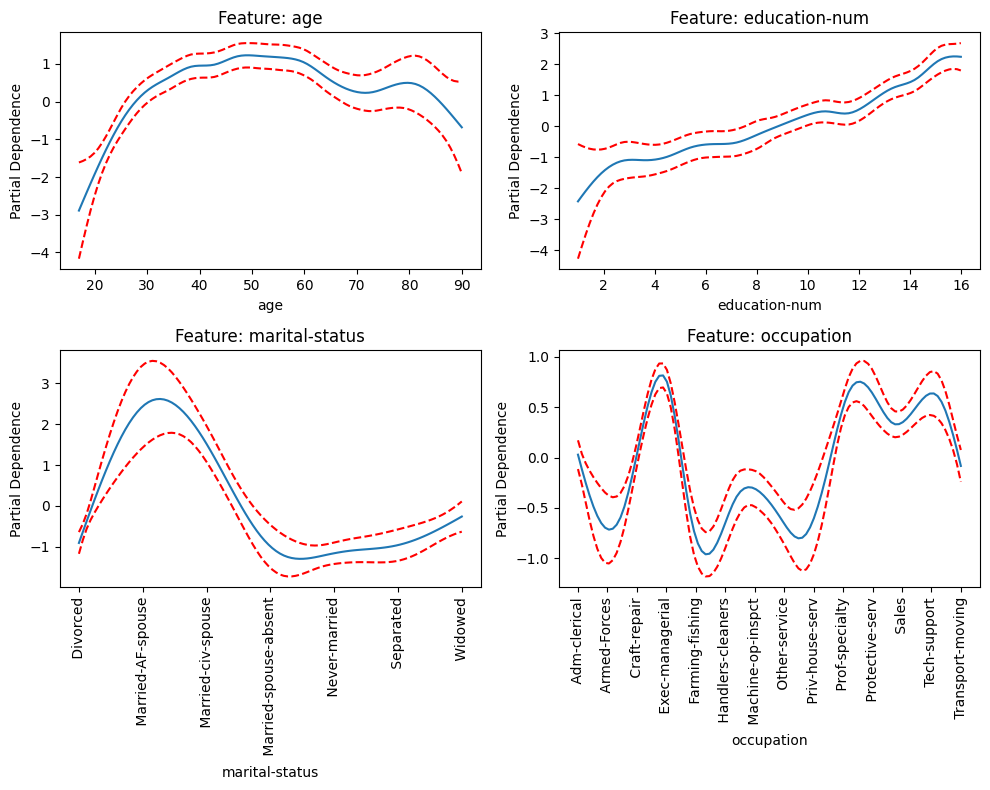

Done


In [14]:
# for the 4 most significant features, plot the shape functions of the GAM model in a 2x2 subplot. 
# rescale the features to their original scale using the saved scaling parameters

# Get the feature names
feature_names = X.columns

# Get the p-values of the features in the GAM model
p_values = gam.statistics_["p_values"]

# Get the indices of the 4 most significant features
top_features_indices = np.argsort(np.abs(p_values))[:4]

# Get the feature names of the 4 most significant features
top_features = [feature_names[int(i)] for i in top_features_indices]

# Rescale the features to their original scale
X_val_rescaled = X_val.copy()
X_val_rescaled[numerical_features] = X_val_rescaled[numerical_features] * np.sqrt(scaler_var) + scaler_mean

# get the mapping for the categorical variables
label_encoders = joblib.load("label_encoders.pkl")

#print the mapping for the categorical variables
# for col in categorical_features:
#     print(f"Mapping for {col}: {dict(enumerate(label_encoders[col].classes_))}")

# Plot the shape functions of the GAM model for the 4 most significant features
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    term_index = int(top_features_indices[i])
    XX = gam.generate_X_grid(term=term_index)
    XX_rescaled = XX.copy()
    if feature_names[term_index] in numerical_features:
        XX_rescaled[:, term_index] = XX[:, term_index] * np.sqrt(scaler_var[numerical_features.index(feature_names[term_index])]) + scaler_mean[numerical_features.index(feature_names[term_index])]
    pdep, confi = gam.partial_dependence(term=term_index, width=.95)
    ax.plot(XX_rescaled[:, term_index], pdep)
    ax.plot(XX_rescaled[:, term_index], confi, c='r', ls='--')
    ax.set_title(f"Feature: {top_features[i]}")
    if feature_names[term_index] in categorical_features:
        ax.set_xticks(range(len(label_encoders[feature_names[term_index]].classes_)))
        ax.set_xticklabels(label_encoders[feature_names[term_index]].classes_, rotation=90)
    ax.set_xlabel(top_features[i])
    ax.set_ylabel("Partial Dependence")
plt.tight_layout()
plt.show()

print("Done")



## Interpretation of GAM model.

1. **Feature: Age**
    -	Strong positive effect from ~20 to 50 years: The probability of earning >$50K increases sharply as age increases.
    -	Peak impact at ~50-55 years: The effect stabilizes at this range.
    -	Declining effect after 60-70 years: Likely due to retirement or reduced working hours.

2. **Feature: Education-Num (Years of education)**

    - The probability of earning >$50K increases almost linearly with education.
    - A more steep increase is visible at 12+ years of education (college degree level).
    - After 16 years, the impact still rises, but at a slightly diminishing rate.
    - Advanced degrees (Master’s, PhD) still improve income, but the return is smaller compared to high school vs. Bachelor’s.

3. **Feature: Marital Status**

    - Married individuals (esp. Married-civ-spouse) have the highest probability of earning >$50K.
    - Divorced & separated individuals show a higher probability than never-married but lower than married individuals.
    - Never-married group has the lowest probability.

4. **Feature: Ocupation**

    - “Exec-managerial”, “Prof-specialty” (Professional jobs) → High positive effect
    - “Sales” & “Tech-support” → Moderate positive effect.
    - “Handlers-cleaners”, “Priv-house-serv”, “Other-service” → Negative or low effect.

